In [74]:
import numpy as np
import scipy.sparse as sps
import os
import random
import sys
import pandas as pd
from numpy import genfromtxt
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt

In [2]:
class BookCrossingReader(object):
    #TODO: aggiungere validation option.
    def __init__(self, train_test_split=None, train_validation_split=None, delete_popular=None, top_popular_threshold=0.33):
        '''
        :param train_test_split: is the percentage of the training set
        '''


        filename = "~/BX-Book-Ratings.csv"
        from numpy import genfromtxt
        fileHandle = pd.read_csv(filename, sep=";", encoding="ISO-8859-1")

        rows, cols, vals = [], [], []
        numCells = 0
        fileHandle['ISBN'], levels = pd.factorize(fileHandle['ISBN'])
        fileHandle['User-ID'], levels = pd.factorize(fileHandle['User-ID'])

        #These arrays are sorted by user
        self.users = np.array(fileHandle['User-ID']).astype(int)
        self.movies = np.array(fileHandle['ISBN']).astype(int)
        self.ratings = np.array(fileHandle['Book-Rating']).astype(float)

        self.unique_movies = np.sort(np.unique(self.movies)).astype(int)
        self.unique_users = np.sort(np.unique(self.users))
        '''
        #These arrays are sorted by item
        self.users_by_item = np.array(data2[:,0])
        self.items_by_item = np.array(data2[:,1])
        self.ratings_by_item = np.array(data2[:,2])
   
        # gli id degli users partono da 1 e sono tutti consecutivi, quindi l'unica
        # riga della URM che ha tutti 0 è la prima (riga 0) che quindi eliminiamo
        '''
        URM_all_partial = sps.csr_matrix((self.ratings, (self.users, self.movies)), dtype=np.float32)
        self.URM_all = URM_all_partial
        self.URM_all = self.URM_all.tocoo()

        num_interactions = self.URM_all.nnz

        train_mask = np.random.choice([True, False], num_interactions, p=[train_test_split, 1 - train_test_split])
        test_mask = np.logical_not(train_mask)

        if train_validation_split is not None:

            splitted_test_mask = [random.choice([True, False]) if x else False for x in test_mask]
            validation_mask = np.logical_and(np.logical_not(splitted_test_mask), test_mask)

            self.URM_validation = sps.csr_matrix((self.ratings[validation_mask], (self.users[validation_mask], self.movies[validation_mask])))

        elif train_test_split is not None:
            train_mask = np.random.choice([True, False], num_interactions, p=[train_test_split, 1 - train_test_split])

            test_mask = np.logical_not(train_mask)

        else:
            raise Exception("One between train_test_split and train_validation_split must be valid")

        self.URM_test = sps.csr_matrix((self.ratings[test_mask], (self.users[test_mask], self.movies[test_mask])))
        self.URM_test = self.URM_test[0:1000, :]

        self.URM_train = sps.csr_matrix((self.ratings[train_mask], (self.users[train_mask], self.movies[train_mask])))
        self.URM_train = self.URM_train[0:1000, :]

dataset = BookCrossingReader(0.99,0.99)

In [35]:
reader = Reader(rating_scale=(1, 10))
df = pd.DataFrame({
    'userID': dataset.users,
    'itemID': dataset.movies,
    'rating': dataset.ratings
})
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [79]:
len(dataset.movies)

1149780

In [36]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [67]:
%%cython
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

cimport numpy as np  # noqa
import numpy as np
from six.moves import range

from surprise.prediction_algorithms.algo_base import AlgoBase
from surprise.prediction_algorithms.predictions import PredictionImpossible
from surprise.utils import get_rng


class SVDpp(AlgoBase):
    def __init__(self, n_factors=20, n_epochs=20, init_mean=0, init_std_dev=.1,
                 lr_all=.007, reg_all=.02, lr_bu=None, lr_bi=None, lr_pu=None,
                 lr_qi=None, lr_yj=None, reg_bu=None, reg_bi=None, reg_pu=None,
                 reg_qi=None, reg_yj=None, random_state=None, verbose=False):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr_bu = lr_bu if lr_bu is not None else lr_all
        self.lr_bi = lr_bi if lr_bi is not None else lr_all
        self.lr_pu = lr_pu if lr_pu is not None else lr_all
        self.lr_qi = lr_qi if lr_qi is not None else lr_all
        self.lr_yj = lr_yj if lr_yj is not None else lr_all
        self.reg_bu = reg_bu if reg_bu is not None else reg_all
        self.reg_bi = reg_bi if reg_bi is not None else reg_all
        self.reg_pu = reg_pu if reg_pu is not None else reg_all
        self.reg_qi = reg_qi if reg_qi is not None else reg_all
        self.reg_yj = reg_yj if reg_yj is not None else reg_all
        self.random_state = random_state
        self.verbose = verbose

        AlgoBase.__init__(self)

    def fit(self, trainset):

        AlgoBase.fit(self, trainset)
        errors = self.sgd(trainset)

        return errors

    def sgd(self, trainset):

        # user biases
        cdef np.ndarray[np.double_t] bu
        # item biases
        cdef np.ndarray[np.double_t] bi
        # user factors
        cdef np.ndarray[np.double_t, ndim=2] pu
        # item factors
        cdef np.ndarray[np.double_t, ndim=2] qi
        # item implicit factors
        cdef np.ndarray[np.double_t, ndim=2] yj

        cdef int u, i, j, f
        cdef double r, err, dot, puf, qif, sqrt_Iu, _
        cdef double global_mean = self.trainset.global_mean
        cdef np.ndarray[np.double_t] u_impl_fdb

        cdef double lr_bu = self.lr_bu
        cdef double lr_bi = self.lr_bi
        cdef double lr_pu = self.lr_pu
        cdef double lr_qi = self.lr_qi
        cdef double lr_yj = self.lr_yj

        cdef double reg_bu = self.reg_bu
        cdef double reg_bi = self.reg_bi
        cdef double reg_pu = self.reg_pu
        cdef double reg_qi = self.reg_qi
        cdef double reg_yj = self.reg_yj

        bu = np.zeros(trainset.n_users, np.double)
        bi = np.zeros(trainset.n_items, np.double)

        rng = get_rng(self.random_state)

        pu = rng.normal(self.init_mean, self.init_std_dev,
                        (trainset.n_users, self.n_factors))
        qi = rng.normal(self.init_mean, self.init_std_dev,
                        (trainset.n_items, self.n_factors))
        yj = rng.normal(self.init_mean, self.init_std_dev,
                        (trainset.n_items, self.n_factors))
        u_impl_fdb = np.zeros(self.n_factors, np.double)
        
        epoch_errors = []
        for current_epoch in range(self.n_epochs):
            if self.verbose:
                print(" processing epoch {}".format(current_epoch))
                print(epoch_errors)
            for u, i, r in trainset.all_ratings():
                all_errors = []
                # items rated by u. This is COSTLY
                Iu = [j for (j, _) in trainset.ur[u]]
                sqrt_Iu = np.sqrt(len(Iu))

                # compute user implicit feedback
                u_impl_fdb = np.zeros(self.n_factors, np.double)
                for j in Iu:
                    for f in range(self.n_factors):
                        u_impl_fdb[f] += yj[j, f] / sqrt_Iu

                # compute current error
                dot = 0  # <q_i, (p_u + sum_{j in Iu} y_j / sqrt{Iu}>
                for f in range(self.n_factors):
                    dot += qi[i, f] * (pu[u, f] + u_impl_fdb[f])
                
                err = r - (global_mean + bu[u] + bi[i] + dot)
                all_errors.append(np.abs(err))

                # update biases
                bu[u] += lr_bu * (err - reg_bu * bu[u])
                bi[i] += lr_bi * (err - reg_bi * bi[i])

                # update factors
                for f in range(self.n_factors):
                    puf = pu[u, f]
                    qif = qi[i, f]
                    pu[u, f] += lr_pu * (err * qif - reg_pu * puf)
                    qi[i, f] += lr_qi * (err * (puf + u_impl_fdb[f]) -
                                         reg_qi * qif)
                    for j in Iu:
                        yj[j, f] += lr_yj * (err * qif / sqrt_Iu -
                                             reg_yj * yj[j, f])
            epoch_errors.append(np.mean(all_errors))

        self.bu = bu
        self.bi = bi
        self.pu = pu
        self.qi = qi
        self.yj = yj
        return epoch_errors

    def estimate(self, u, i):

        est = self.trainset.global_mean

        if self.trainset.knows_user(u):
            est += self.bu[u]

        if self.trainset.knows_item(i):
            est += self.bi[i]

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            Iu = len(self.trainset.ur[u])  # nb of items rated by u
            u_impl_feedback = (sum(self.yj[j] for (j, _)
                               in self.trainset.ur[u]) / np.sqrt(Iu))
            est += np.dot(self.qi[i], self.pu[u] + u_impl_feedback)

        return est

In [68]:
data = Dataset.load_builtin('ml-100k')

In [69]:
svd = SVDpp(n_epochs=100, verbose=True)

train, test = train_test_split(data)
result = svd.fit(train)
#     predictions = svd.test(test)
#     rmse = accuracy.rmse(predictions)
#     print(rmse)
    
result = cross_validate(svd, data,
                        measures=['rmse', 'mae'],
                        return_train_measures=True, verbose=True, n_jobs=40)

 processing epoch 0
[]
 processing epoch 1
[0.73051565894409]
 processing epoch 2
[0.73051565894409, 0.5624088901402198]
 processing epoch 3
[0.73051565894409, 0.5624088901402198, 0.49950310737108516]
 processing epoch 4
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926]
 processing epoch 5
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374]
 processing epoch 6
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113]
 processing epoch 7
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694]
 processing epoch 8
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722]
 processing epoch 9
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.4638586

 processing epoch 28
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036]
 processing epoch 29
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.287814382

 processing epoch 40
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712]
 processing epoch 41
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.4055775281

 processing epoch 49
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 57
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 64
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 70
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 76
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 82
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 87
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 92
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

 processing epoch 97
[0.73051565894409, 0.5624088901402198, 0.49950310737108516, 0.46385864467416926, 0.43920484394925374, 0.42059311746490113, 0.405577528181694, 0.3925576848501722, 0.38044375076447334, 0.36857501812637317, 0.35667953726978574, 0.3448233010853974, 0.33331014295203065, 0.32253321127374335, 0.31284076329921806, 0.30446575815569776, 0.29751497100050983, 0.29198947511171447, 0.2878143826677002, 0.28486740240368746, 0.28300260675576894, 0.2820683834579416, 0.28191951230158097, 0.28242398146563996, 0.283465693298977, 0.28494443830805416, 0.2867744019179259, 0.28888213886570036, 0.2912045743798224, 0.2936872864492095, 0.29628313036075493, 0.29895117235411206, 0.30165586944234324, 0.30436643448529654, 0.30705633782262076, 0.3097029086958081, 0.31228700828697065, 0.31479275196875545, 0.3172072626718654, 0.3195204411647712, 0.3217247429076009, 0.32381495492644685, 0.3257879695926347, 0.32764255502491935, 0.3293791239091366, 0.3309995038257245, 0.3325067127695984, 0.333904743578

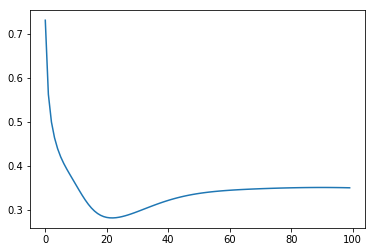

In [76]:
plt.plot(result)